### AcO_M1Pos_FEM_cl_seg1-6_mount_bm

In [ ]:
import dos
from IPython.display import Image
path = './dos/AcO_M1Pos_FEM_cl_seg1-6_mount_bm'

In [ ]:
# init
sim = dos.DOS(path, 20, show_timing = 2)
Image(filename=path + '/timing.png')

In [ ]:
sim.start()

In [ ]:
sim.join()
sim.terminate()

logs = sim.logs.entries

# plot logs
---

In [ ]:
import matplotlib.pyplot as plt
try:
    from jupyterthemes import jtplot
    jtplot.style()
except:
    pass

import numpy as np

try:
    duration = sim.cfg['simulation']['duration']
except NameError:
    duration = logs['FEM']['OSS_M1_lcl'].timeSeries[0][-1]
    
xticks = np.arange(0, duration + 1, duration/ 10)

logs

#####  Save

---

In [ ]:
import numpy as np

signal_name   = 'bendingmodes'
signal_values = sim.logs.entries['FEM']['bending_modes'].timeSeries[1].T

saved_mem_map = np.memmap('./variables/'+signal_name+'.dat',
                          dtype=np.float32, mode='w+', shape=signal_values.shape)
saved_mem_map[:,:] = signal_values[:,:]

del saved_mem_map
del signal_values

In [ ]:
import scipy.io as sio
import yaml
with open(path + r'/FEM.yaml') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)
    
fem_io = cfg['FEM']['build']['fem_io_filename']
fem_ss = cfg['FEM']['build']['state_space_filename']

shape_st_ = (11000, duration*2000+1)
states = np.memmap('./variables/states.dat', dtype=np.float32, mode='r+', shape=shape_st_)
states
C = sio.loadmat(fem_ss)['C']

data = sio.loadmat(fem_io)
fem_outputs=[(x[0][0],y[0]) for x,y in zip(data['FEM_IO']['outputs_name'][0,0],
                                           data['FEM_IO']['outputs_size'][0][0])]

i_sum, i_, ii_ = 0, 0, 0
for k in fem_outputs:
    if k[0] != 'M1_surfaces_d':
        i_sum += k[1]
    else:
        ref_size = k[1]
        i_, ii_ = i_sum, i_sum + ref_size

C = C[i_:ii_,:]
indexes = range(2,C.shape[0],3)
C = C[indexes, :]

displacements_ptt = np.dot(C, states)

# save memmap ------------------
signal_name   = 'displacements_ptt'
signal_values_ptt = displacements_ptt

saved_mem_map = np.memmap('./variables/'+signal_name+'.dat',
                          dtype=np.float32, mode='w+', shape=displacements_ptt.shape)

saved_mem_map[:,:] = signal_values_ptt[:,:]

print(signal_values_ptt.shape)

del saved_mem_map
del signal_values_ptt

##### Load

---

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style()
path = './dos/AcO_M1Pos_FEM_cl_seg1-6_mount_bm'
try:
    duration = sim.cfg['simulation']['duration']
except NameError:
    duration = 10
    
import yaml
with open(path + r'/FEM.yaml') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)
    
    
displacements_ptt = np.memmap('./variables/displacements_ptt.dat',
                              dtype=np.float32, mode='r+',
                              shape=(5127, duration*2000 + 1))

bendingmodes = np.memmap('./variables/bendingmodes.dat',
                          dtype=np.float32, mode='r+',
                          shape=(1144, duration*2000 + 1))

print('Bending modes shape:', bendingmodes.shape)
print('displacements shape:', displacements_ptt.shape)

Bending modes shape: (1144, 20001)
displacements shape: (5127, 20001)


#### Surface displacement

In [2]:
indc1 = [x*742 for x in range(1,7)]
seg_displacements_ptt = np.split(displacements_ptt,
                                 indices_or_sections = indc1,
                                 axis = 0)

transformation_path = cfg['FEM']['build']['output_support']['bending_modes']['path']

Q_ = sio.loadmat(transformation_path)['Q_']
Q_seg = np.split(Q_, indices_or_sections = indc1, axis = 0)

##### Displacements -> BM -> Displacements

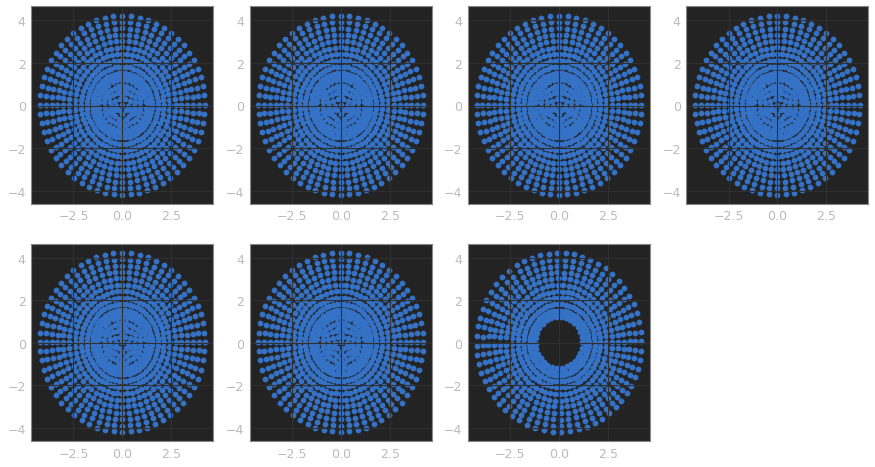

In [4]:
plt.figure(figsize=(15,8))
for i in range(7):
    plt.subplot(2,4,i+1)
    plt.scatter(Q_seg[i][:,0],Q_seg[i][:,1])

In [5]:
from matplotlib import ticker, cm
from scipy.linalg import norm as scinorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

def u_analysis(U):

    A = np.dot(U.T,U)
    
    fig = plt.figure(figsize=(16, 12))
    ax1 = fig.add_subplot(121)
    im1 = ax1.imshow(A, interpolation='None')
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    print("norm(U.t * U - I) =",scinorm(A - np.eye(A.shape[0])))

    B = np.dot(U, U.T)
    ax2 = fig.add_subplot(122)
    im2 = ax2.imshow((B), interpolation='None')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical');
    
    plt.figure(figsize = (16,5))
    plt.plot(np.diag(B))
    plt.show()

    print(np.mean(np.diag(B)))
    
    print("norm(U * U.t - I) =",scinorm(B - np.eye(B.shape[0])))

In [6]:
U_ = sio.loadmat(transformation_path)['U_'] #Stiffness

In [8]:
from utils import LargeCompute

lc = LargeCompute(onCuda=True)

disp_noPTT1 = lc.remove_ptt_from_disp(Q_seg[0], seg_displacements_ptt[0])
bm = lc.dot_time(U_[0,0].T, disp_noPTT1)
disp_noPTT2 = lc.bm_to_disp_time(U_[0,0], bm)

[]

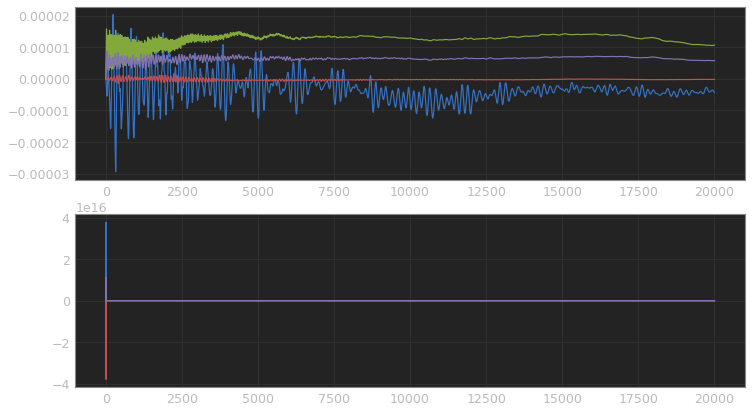

In [9]:
index = [1, 2, 3, 4 ]

plt.figure(figsize = (12, 7))
plt.subplot(211)
plt.plot(bendingmodes[index, :].T)
plt.subplot(212)
plt.plot(bm[index, :].T)
plt.plot()

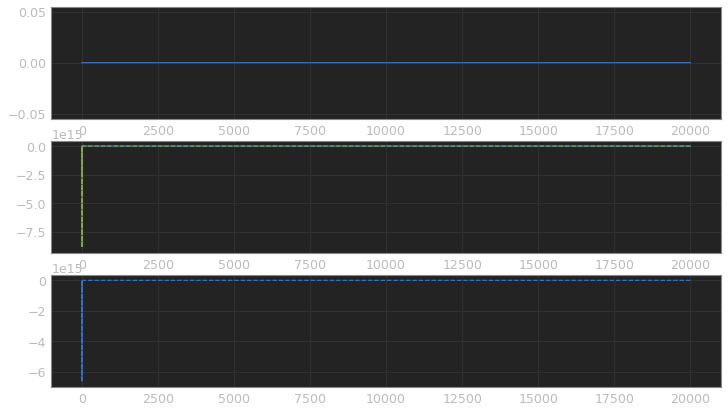

In [10]:
%matplotlib inline

nodes = [1]

plt.figure(figsize= (12,7))
plt.subplot(311)
plt.plot(seg_displacements_ptt[0][nodes,:].T)
plt.subplot(312)
plt.plot(disp_noPTT1[nodes,:].T)
plt.plot(disp_noPTT2[nodes,:].T , '--')
plt.subplot(313)
plt.plot(disp_noPTT2[nodes,:].T - disp_noPTT1[nodes,:].T , '--')
plt.show()

In [11]:
def remove_ptt(seg_displacements_ptt, Q):
    n_samples = seg_displacements_ptt.shape[1]
    n_nodes = seg_displacements_ptt.shape[0]

    displacements_noptt_ = np.empty([n_nodes, n_samples], dtype=np.float32)
    ptt = np.empty([n_nodes, n_samples], dtype=np.float32)
    
    for k in range(displacements_noptt_.shape[1]):
        _aux = np.linalg.lstsq(Q, seg_displacements_ptt[:,k])[0]
        ptt[:,k] = np.dot(Q, _aux)
        displacements_noptt_[:,k] = seg_displacements_ptt[:,k] - ptt[:,k]
    return displacements_noptt_

def disp_to_bm(disp_noPTT, U):
    return np.dot(U.T, disp_noPTT) # returns bm

def bm_to_disp(bm, U):     
    result = np.zeros([U.shape[0], bm.shape[1]])
    for k in range(bm.shape[1]):
        aux = np.dot(U, np.diag(bm[:,k])) 
        result[:,k] = np.sum(aux, axis = 1)
    return result # returns displacements

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def plot_surf(z1, z2):

    x = Q_seg[0][:,0]
    y = Q_seg[0][:,1]

    # Compute z to make the pringle surface.

    fig = plt.figure(figsize = (20,7))
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(1, 3, 1, projection='3d', proj_type = 'ortho')
    surf1 = ax.plot_trisurf(x, y, z1, linewidth=0.2, antialiased=True, cmap=cm.coolwarm)
    ax.view_init(90, 0)
    fig.colorbar(surf1, shrink=0.5, aspect=10)
    
    #fig = plt.figure(figsize = (15,10))
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(1, 3, 2, projection='3d', proj_type = 'ortho')
    surf2 =ax.plot_trisurf(x, y, z2, linewidth=0.2, antialiased=True, cmap=cm.coolwarm)
    ax.view_init(90, 0)
    fig.colorbar(surf2, shrink=0.5, aspect=10)
    
    #fig = plt.figure(figsize = (15,10))
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(1, 3, 3, projection='3d', proj_type = 'ortho')
    surf3 = ax.plot_trisurf(x, y, z1-z2, linewidth=0.2, antialiased=True, cmap=cm.coolwarm)
    ax.view_init(90, 0)
    fig.colorbar(surf3, shrink=0.5, aspect=10)

    plt.show()

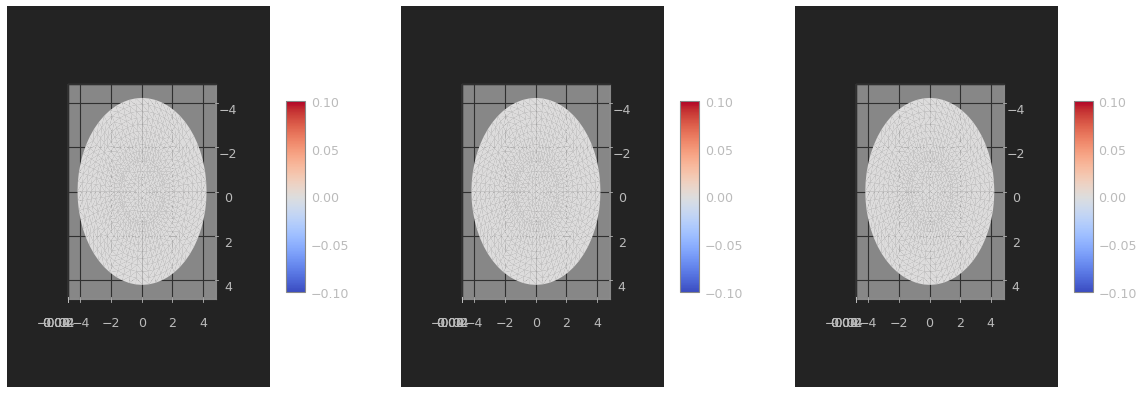

In [13]:
plot_surf(disp_noPTT1[:,1500], disp_noPTT2[:,1500])

In [14]:
scinorm(disp_noPTT1 -  disp_noPTT2)/scinorm(disp_noPTT1)

0.93218404

 ---

In [ ]:
index = [1, 2, 3, 4]

plt.figure(figsize = (12,4))
plt.plot(seg_bendingmodes[0][index,:].T)
plt.show()

In [ ]:
indc2 = [x*165 for x in list(range(1,7))]
seg_bendingmodes = np.split(bendingmodes, indices_or_sections = indc2, axis = 0)

# Remove last 3bm for all segments
for seg in range(7):
    seg_bendingmodes[seg][:,-3:] = np.zeros(seg_bendingmodes[seg][:,-3:].shape)

In [ ]:
disp_noPTT_bm = lc64.bm_to_disp_time(U_, seg_bendingmodes[0], vartype=np.float64)

In [ ]:
plot_surf(disp_noPTT1[:,1500], disp_noPTT_bm[:,1500])

##### Compute

---

In [ ]:
seg_displacements_ptt[6].shape

In [ ]:
seg_bendingmodes[0].shape

In [ ]:
indexes = [1,2,3,4]

plt.figure(figsize = (15,7))
plt.plot(seg_bendingmodes[0][indexes,:].T)
plt.show()

##### Displacements to bending modes

In [ ]:
from utils import LargeCompute
lc = LargeCompute(onCuda=True)
lc_noCuda = LargeCompute(onCuda=False)

In [ ]:
# Remove ptt seg 0

seg = 0
displacements_noptt = lc.remove_ptt_from_disp(Q_seg[seg], seg_displacements_ptt[seg])

displacements_noptt_ = np.empty([742,duration*2000+1], dtype=np.float32)
for k in range(displacements_noptt_.shape[1]):
    _aux = np.linalg.lstsq(Q_seg[seg], seg_displacements_ptt[seg][:,k])[0]
    displacements_noptt_[:,k] = seg_displacements_ptt[seg][:,k] - np.dot(Q_seg[seg], _aux)

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(displacements_noptt[2,:])
plt.plot(displacements_noptt_[2,:], '--')
plt.show()

In [ ]:
# Revocer bending modes
bm_rec = np.dot(U_[0,0].T, displacements_noptt_)

#### Plot rec bm

In [ ]:
indexes = [1,2,3,4]

plt.figure(figsize = (15,7))
plt.subplot(2,1,1)
plt.plot(seg_bendingmodes[0][indexes,:].T)
plt.subplot(2,1,2)
plt.plot(bm_rec[indexes,:].T)
plt.show()

##### Large Compute

In [ ]:
# Large compute

from utils import LargeCompute
lc = LargeCompute(onCuda=True)

lc_bm_displacements = [0]*7
lc_displacements = [0]*7

for seg in range(7):
    lc_bm_displacements[seg] = lc.bm_to_disp_time(U_[seg,0].T, fem_bm[seg].T)
    lc_displacements[seg] = lc.remove_ptt_from_disp(Q_seg[seg], displacements_ptt[seg])

##### Remove ptt from displacements (M1_surfaces_d)

In [ ]:
displacements = np.empty([duration*2000+1, 7, 742], dtype=object)

for seg in range(1):
    for k in range(displacements.shape[0]):
        _aux = np.linalg.lstsq(Q_seg[seg], displacements_ptt[seg][:,k])[0]
        displacements[k, seg, : ] = displacements_ptt[seg][:,k] - np.dot(Q_seg[seg], _aux)

In [ ]:
displacements[:,0,:].shape

In [ ]:
bmodes = lc.dot_time(U_[0,0].T, displacements[:,0,:].T, varname='bendingmodes')
bmodes.shape

##### BM to displacements

In [ ]:
bm_displacements = np.empty([duration*2000+1, 7], dtype=object)

for seg in range(7):
    for k in range(bm_displacements.shape[0]):
        bm_displacements[k, seg] = np.dot(U_[seg,0],fem_bm[seg][k,:].T)

In [ ]:
# BM to displacements with diag()
bm_displacements_diag = np.empty([duration*2000+1, 7], dtype=object)

for seg in range(7):
    for k in range(fem_bm[0].shape[0]):
        _diag_bm = np.diag(fem_bm[seg][k,:].T)
        _disp = np.dot(U_[seg,0], _diag_bm)
        _disp = np.sum(_disp, axis=1)
        bm_displacements_diag[k, seg] = _disp[:]

In [ ]:
bmodes[indexes, :].T.shape

In [ ]:
indexes = [1,2,3,4]

plt.figure(figsize = (15,15))
plt.subplot(2,1,1)
plt.plot(fem_bm[0][:,indexes])
plt.subplot(2,1,2)
plt.plot(bmodes[indexes, :].T)
plt.show()

In [ ]:
# Plot

seg = 0
node = [1,2,3,4]

plt.figure(figsize = (15,7))
plt.subplot(2,1,1)
plt.plot(lc_bm_displacements[seg][node ,:].T)
#plt.plot([x[node] for x in bm_displacements[:, seg]])
#plt.plot([x[node] for x in bm_displacements_diag[:, seg]], '--')
plt.subplot(2,1,2)
#plt.plot(lc_displacements[seg][node,:].T, )
plt.plot([x[node] for x in displacements[:, seg]], '--')

plt.show()